# Load modules and data

In [1]:
import glob
from helpers import line_intersection3
from itertools import groupby
from helpers import line_intersection3, track_tools
from itertools import groupby
import pandas as pd
import os
from itertools import compress
import numpy as np
from p_tqdm import p_map

## Vectorize information about file location for better efficiency

In [2]:
species=list(map(lambda x: x.split("/")[1],glob.glob("Track_Data_processed/*/")))
vectorized=list()
for spe in species:
    path = 'Track_Data_processed/'+spe
    files = [f for f in glob.glob(path + "/**/all_tracks.csv", recursive=True)]
    for i in range(len(files)):
        vectorized.append([spe,i])

In [3]:
species

['E. lamellosa',
 'S. calliendrum',
 'P. decussata',
 'S. pistillata',
 'P. cactus',
 'M. scabricula',
 'M. foliosa',
 'M. efflorescens']

In [4]:
len(vectorized)

35

## functions that will load the data 

In [5]:
numcores=21


#specie=["Echinopora"]

def gather_dat(vector):
    spe=vector[0]
    rep=vector[1]
    path = 'Track_Data_processed/'+spe
    scale=pd.read_table('Track_Data_processed/'+spe+'/scale',header=0)
    sc=scale["real_distance"][0]/scale["imaris_distance"][0]
    fl=next(os.walk(path))[1]
    fl=list(compress(fl, list(map(lambda x: x!=".ipynb_checkpoints",fl))))
    files = [f for f in glob.glob(path + "/**/all_tracks.csv", recursive=True)]
    adata=pd.concat(list(map(pd.read_csv,files)),keys=list(range(0,len(files))))

    allparents=np.unique(adata.loc[rep]["Parent"])
    allparents=allparents[~np.isnan(allparents)]

    ldata=list(map(lambda x: adata.loc[rep][["Position X","Position Y","Time"]].loc[adata.loc[rep].index[adata.loc[rep]["Parent"].isin([x],)]], 
                         [par for par in allparents]))
    ldata=list(map(track_tools.distances_accelerations,ldata))
    results = list(map(track_tools.sinuosities_max, ldata))
    turns=list(map(lambda y: sum([x[0] for x in groupby(y["sinuosity"]>1.1)]), results))
    sin=list(map(track_tools.sinuosities_track, ldata))
    length=list(map(lambda x: np.nansum(x["dst"]),ldata))
    npoints=list(map(lambda x: len(x["dst"]),ldata))
    speedvar=list(map(lambda x: np.nanvar(x["acc"]),ldata))
    speedmean=list(map(lambda x: np.nanmean(x["dst"]),ldata))

    lseg=list(map(lambda x: np.hstack([x.values[:-1,:2],x.values[1:,:2]]).tolist(),ldata))
    inter=list(map(lambda x: len(list(line_intersection3.line_intersections(x))),lseg))

    A=[turns,sin,length,npoints,speedmean,speedvar,inter]
    dat=pd.DataFrame(A).T
    dat.columns=["turns","sin","length","npoints","speedmean","speedvar","inter"]
    dat["rep"]=rep
    dat["specie"]=spe
        
    return(dat)



## Getting the data

In [6]:
alldat=p_map(gather_dat,vectorized)

  0%|          | 0/35 [00:00<?, ?it/s]

/home/lfaure/Analysis/Corals/coral_paper/helpers/track_tools.py:56: RuntimeWarning: invalid value encountered in double_scalars
  return(sum(ldata["dist"].values[1:])/ppd)
/tmp/ipykernel_1693305/1514119868.py:28: RuntimeWarning: Degrees of freedom <= 0 for slice.
  speedvar=list(map(lambda x: np.nanvar(x["acc"]),ldata))
/tmp/ipykernel_1693305/1514119868.py:28: RuntimeWarning: Degrees of freedom <= 0 for slice.
  speedvar=list(map(lambda x: np.nanvar(x["acc"]),ldata))
/tmp/ipykernel_1693305/1514119868.py:28: RuntimeWarning: Degrees of freedom <= 0 for slice.
  speedvar=list(map(lambda x: np.nanvar(x["acc"]),ldata))


In [7]:
alldat=pd.concat(alldat)

In [8]:
alldat.shape

(11010, 9)

# UMAP Analysis

## Extracting features

In [9]:
species=alldat["specie"]
features=["turns","sin","speedmean","speedvar","inter"]
x = alldat.loc[:, features].values

## Remove NAN entries and standardize the data

In [10]:
idx_torem=(np.argwhere(np.apply_along_axis(lambda y: any(np.isnan(y)),1,x))).flatten().tolist()
alldat=alldat.reset_index()
alldat=alldat.drop(idx_torem)
species=np.delete(species.values,idx_torem)
x=np.delete(x,idx_torem,axis=0)
#x = StandardScaler().fit_transform(x)

In [11]:
import scanpy as sc
import matplotlib.pyplot as plt
plt.rcParams["svg.fonttype"] = "none"
plt.rcParams["font.family"] = ["sans-serif"]
plt.rcParams["font.sans-serif"] = ["Arial"]
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["savefig.bbox"] = "tight"

In [12]:
adata=sc.AnnData(x,obs=alldat[["index","specie","rep"]])

/home/lfaure/miniconda3/envs/dyntrack/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [13]:
adata.var_names=["turns","sin","speedmean","speedvar","inter"]

In [14]:
adata.raw=adata
sc.pp.scale(adata)

In [15]:
sc.pp.neighbors(adata,n_neighbors=30,metric="correlation")

In [16]:
sc.tl.umap(adata,min_dist=.2)

In [17]:
adata.obs.specie.value_counts()

P. decussata       2419
P. cactus          1901
M. scabricula      1839
S. pistillata      1612
E. lamellosa       1269
M. foliosa          899
M. efflorescens     811
S. calliendrum      257
Name: specie, dtype: int64

/home/lfaure/miniconda3/envs/dyntrack/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'specie' as categorical


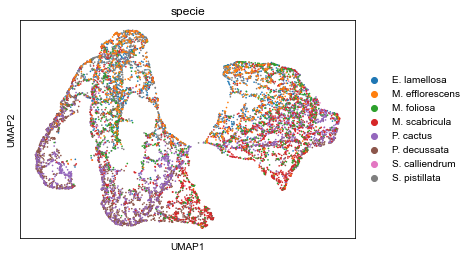

In [18]:
sc.pl.umap(adata,color="specie")

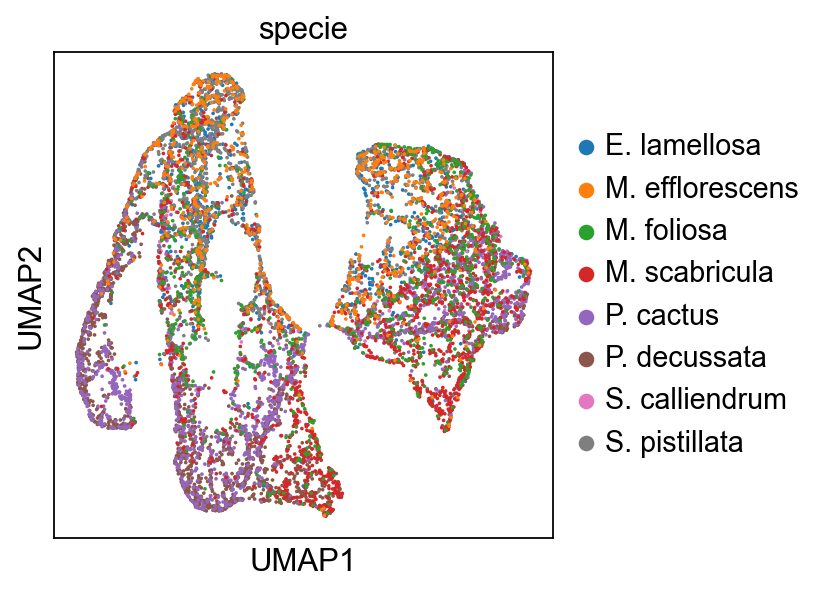

In [19]:
sc.set_figure_params(dpi_save=300)
sc.pl.umap(adata,color="specie",save="species")

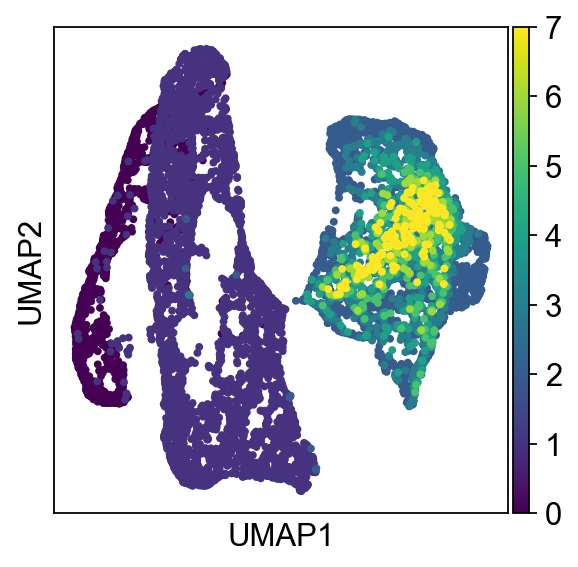

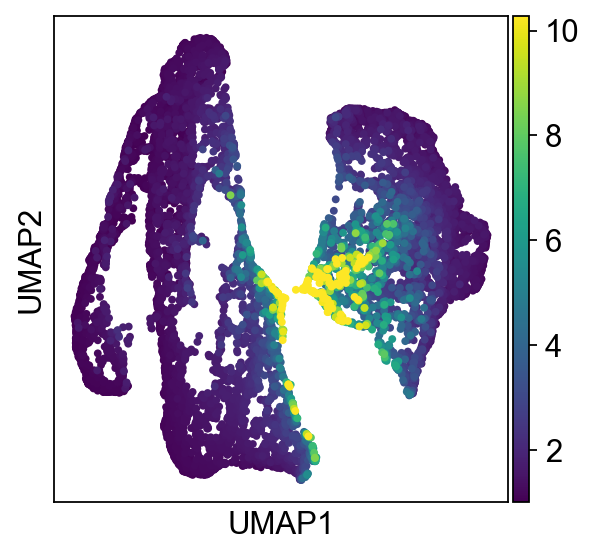

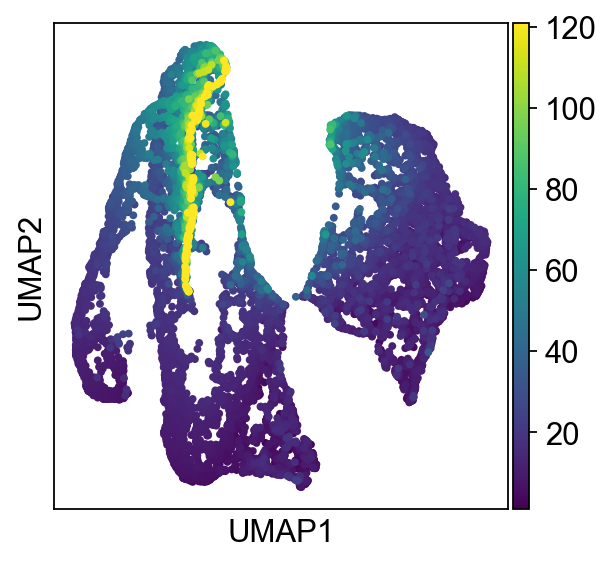

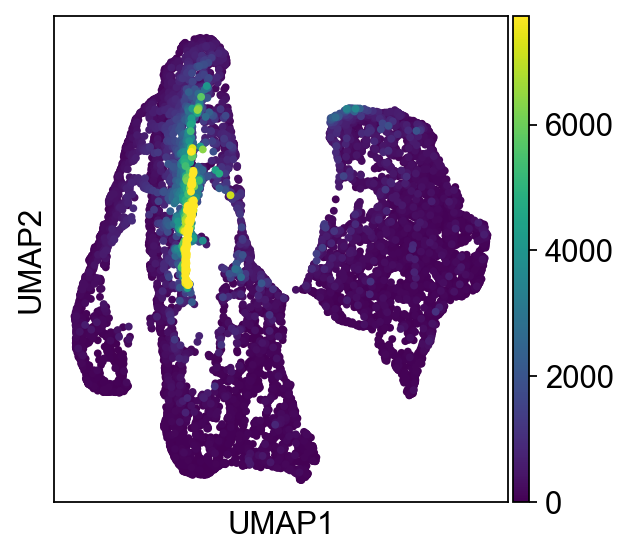

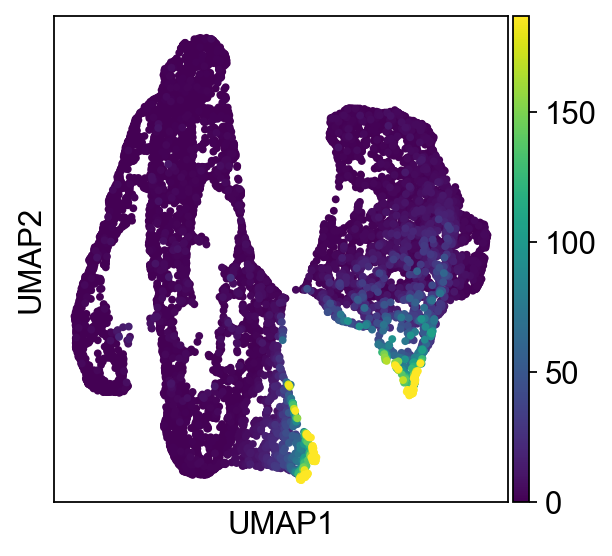

In [20]:
for v in adata.var_names:
    sc.pl.umap(adata,color=v,title="",s=50,save=v,vmax="p99")

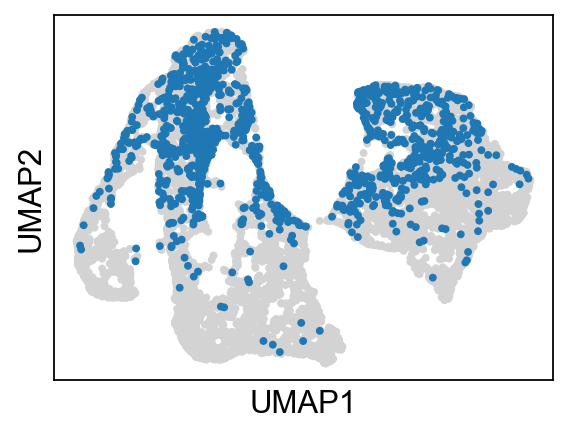

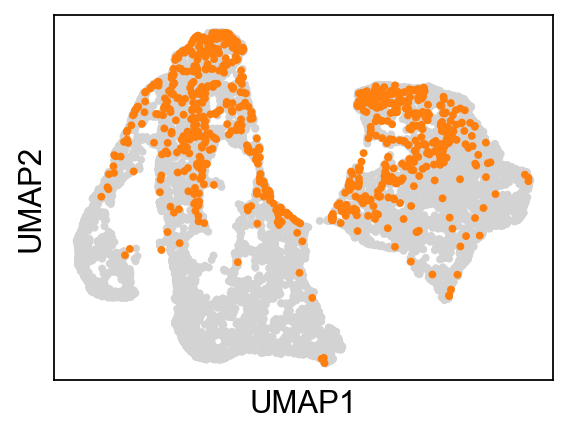

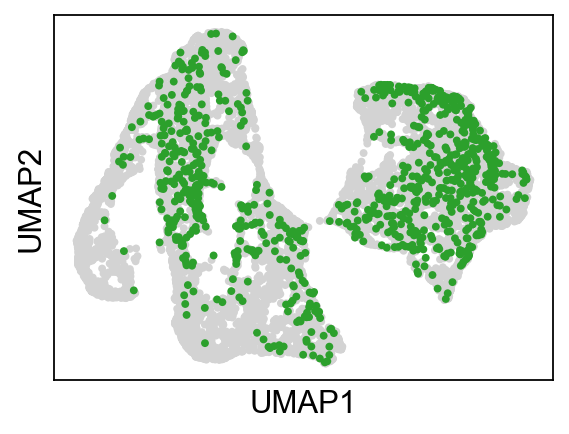

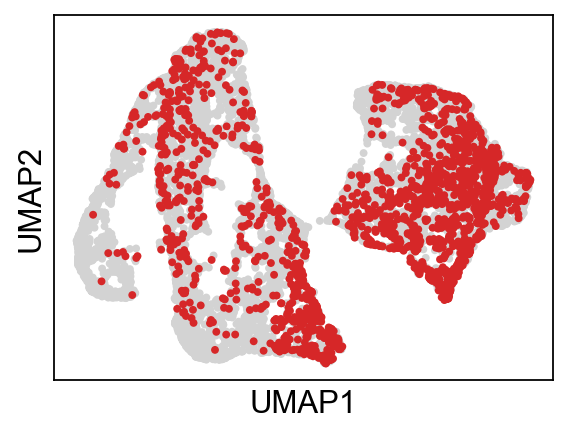

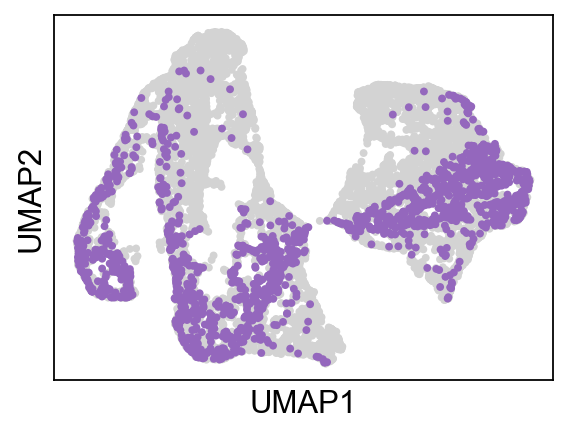

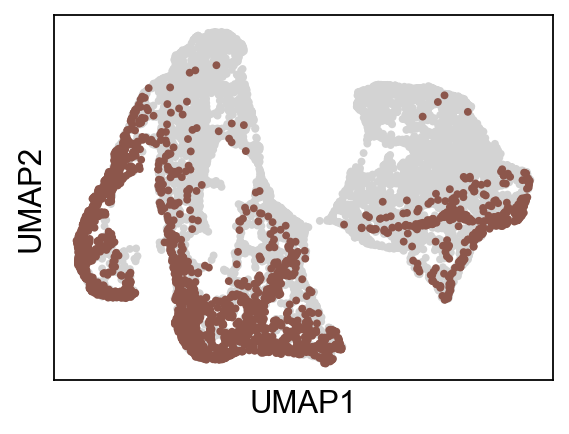

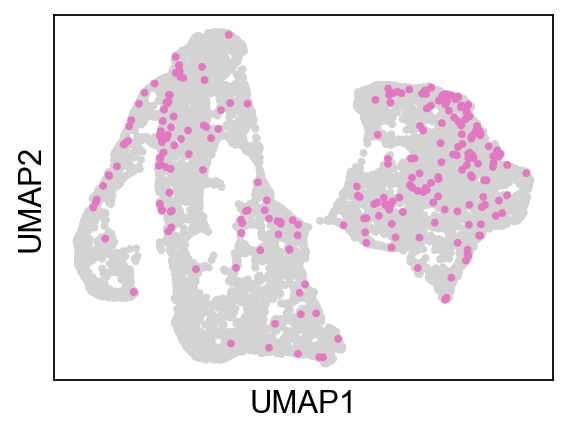

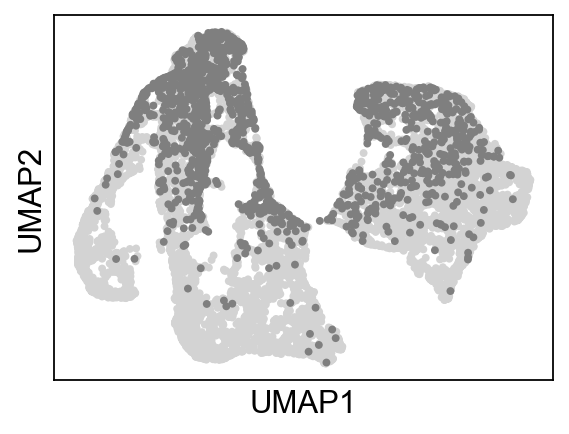

In [21]:
sc.set_figure_params(dpi_save=300,figsize=(4,3))
for s in adata.obs.specie.cat.categories:
    sc.pl.umap(adata,color="specie",groups=[s],title="",s=50,save=s,legend_loc="none")

In [22]:
sc.tl.leiden(adata,resolution=.05)

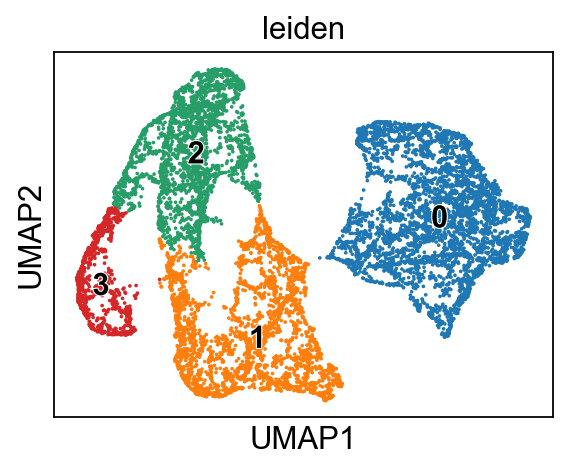

In [23]:
sc.pl.umap(adata,color="leiden",legend_loc="on data",legend_fontoutline=True,save="leiden.pdf")

In [24]:
import seaborn as sns

In [25]:
import proportion

In [26]:
res=[]
for s in adata.obs.specie.cat.categories:
    adata.obs["focus"]=(adata.obs.specie==s).astype(str)
    adata.obs["focus"]=adata.obs["focus"].replace(["True","False"],[s,"rest"])
    res.append(proportion.proportion_test(adata,"focus","leiden",s,"rest",n_jobs=20))

100%|██████████| 1000/1000 [00:00<00:00, 1654.29it/s]


In [27]:
res[0]

,E. lamellosa,rest,obs_log2FD,pval,fdr,boot_mean_log2FD,boot_CI_2.5,boot_CI_97.5,significance
clusters,,,,,,,,,
0,0.393223,0.394640,0.005188,0.474525,0.474525,0.002955,-0.099214,0.099265,n.s.
1,0.079590,0.284658,1.838567,0.000999,0.001332,1.850232,1.593441,2.141196,FDR < 0.05 & abs(Log2FD) > 0.58
2,0.513790,0.225200,-1.189971,0.000999,0.001332,-1.188072,-1.276974,-1.100685,FDR < 0.05 & abs(Log2FD) > 0.58
3,0.013396,0.095502,2.833691,0.000999,0.001332,2.887803,2.238262,3.663421,FDR < 0.05 & abs(Log2FD) > 0.58


In [28]:
import matplotlib.patches as mpatches
def plot_proportion_test(prop_res,sort=True,show_legend=True,show_bootstrap=True,ax=None,show=None):
    prop_res = prop_res.copy()
    
    exclu=(prop_res.iloc[:,:2]==0)
    exclu_cl=exclu[exclu.apply(lambda x: x.sum(),axis=1)==1].idxmin(axis=1)
    exclu_all=exclu[exclu.apply(lambda x: x.sum(),axis=1)==2].index
    txt=list(map(lambda i: "cells from cluster "+str(exclu_cl.index[i])+" only present in "+str(exclu_cl.values[i]),range(len(exclu_cl))))
    txt2=list(map(lambda i: "no cells from cluster "+exclu_all[i],range(len(exclu_all))))
    toadd = "\n".join(txt+txt2)
    
    prop_res.reset_index(inplace=True)
    
    prop_res = prop_res.loc[np.isfinite(prop_res[["pval",
                                                   "fdr",
                                                   "boot_mean_log2FD",
                                                   "boot_CI_2.5",
                                                   "boot_CI_97.5"]]).apply(all,axis=1)]
    if sort:
        prop_res=prop_res.sort_values("obs_log2FD",ascending=False)
        
    if ax is None:
        fig, ax = plt.subplots()

    ax.scatter(prop_res.obs_log2FD,
               prop_res.clusters,c="grey")

    ax.scatter(prop_res.obs_log2FD[prop_res.significance=="n.s."],
               prop_res.clusters[prop_res.significance=="n.s."],
               label="n.s.",c="darkgrey")
    
    if show_bootstrap:
        for c in prop_res.clusters[prop_res.significance=="n.s."].index:
            ax.plot([prop_res.loc[c,"boot_CI_2.5"],prop_res.loc[c,"boot_CI_97.5"]],
                    [prop_res.loc[c,"clusters"],prop_res.loc[c,"clusters"]],c="darkgrey")
    else:
        for i in range(prop_res.shape[0]):
            ax.plot([0,prop_res.obs_log2FD[i]],
                    [prop_res.clusters[i],prop_res.clusters[i]],
                    c="grey")
        
    if (prop_res.significance!="n.s.").sum()>0:
        signi=prop_res.significance[prop_res.significance!="n.s."].unique()[0]

        ax.scatter(prop_res.obs_log2FD[prop_res.significance!="n.s."],
                   prop_res.clusters[prop_res.significance!="n.s."],
                   label=signi,c="tomato")
        if show_bootstrap:
            for c in prop_res.clusters[prop_res.significance!="n.s."].index:
                ax.plot([prop_res.loc[c,"boot_CI_2.5"],prop_res.loc[c,"boot_CI_97.5"]],
                        [prop_res.loc[c,"clusters"],prop_res.loc[c,"clusters"]],c="tomato")
        
        ax.axvline(-np.float32(signi.split("> ")[1]),c="k",linestyle="--")
        ax.axvline(np.float32(signi.split("> ")[1]),c="k",linestyle="--")

    ax.axvline(0,c="k")

    
    
    ax.set_xlabel("obs_log2FD")
    ax.set_ylabel("clusters")
    
    
    if show_legend:
        # where some data has already been plotted to ax
        handles, labels = ax.get_legend_handles_labels()

        # manually define a new patch 
        patch = mpatches.Patch(color='grey', label=toadd,alpha=0)

        # handles is a list, so append manual patch
        handles.append(patch) 
        ax.legend(handles=handles,bbox_to_anchor=(1.05, 1), loc='upper left')
    
    samples=exclu.columns
    
    #ax.set_title(samples[0]+r"$\leftrightarrow$"+samples[1])
    ax.set_title(samples[0]+r"$\leftarrow$",loc="left")
    ax.set_title(r"$\rightarrow$"+samples[1],loc="right")
    
    if show==False:
        return ax
    

/tmp/ipykernel_1693305/19131609.py:28: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  ax.scatter(prop_res.obs_log2FD[prop_res.significance=="n.s."],
/tmp/ipykernel_1693305/4275582251.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


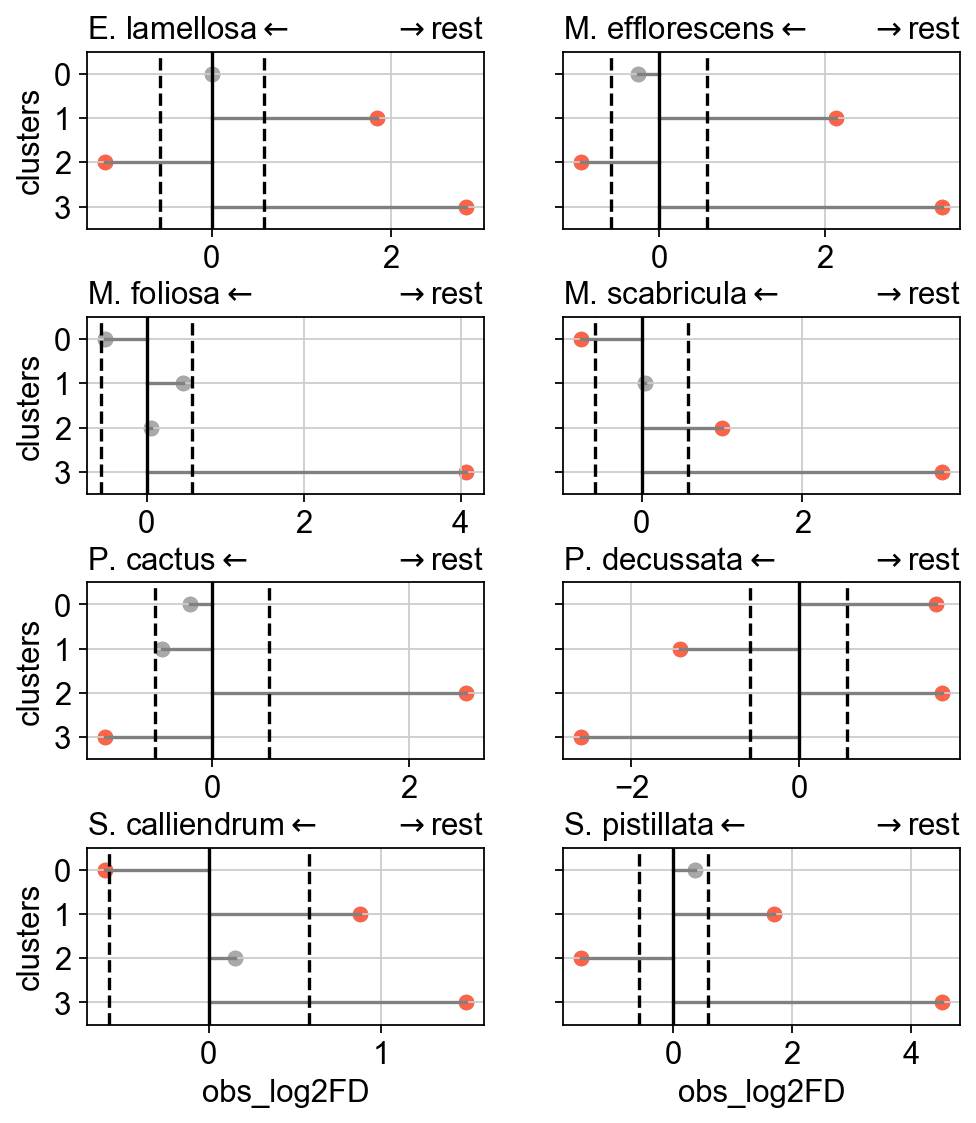

In [29]:
fig, axs=plt.subplots(4,2,figsize=(7,8),sharey=True,gridspec_kw=dict(hspace=.5))
axs=axs.ravel()
for i,r in enumerate(res):
    plot_proportion_test(r.iloc[::-1],sort=False,ax=axs[i],
                         show_bootstrap=False,show_legend=False)
    if i<6:
        axs[i].set_xlabel("")
    if np.isin(i,[1,3,5,7]):
        axs[i].set_ylabel("")
    axs[i].set_ylim([-.5,3.5])
plt.tight_layout()
plt.savefig("props.pdf")

In [30]:
writer = pd.ExcelWriter('props.xlsx', engine='xlsxwriter')
for r,s in zip(res,adata.obs.specie.cat.categories):
    r.iloc[:,:5].to_excel(writer,sheet_name=s)
writer.save()

In [31]:
sc.tl.rank_genes_groups(adata,"leiden")

/home/lfaure/miniconda3/envs/dyntrack/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'focus' as categorical
/home/lfaure/miniconda3/envs/dyntrack/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:418: RuntimeWarning: overflow encountered in expm1
  self.expm1_func(mean_rest) + 1e-9
/home/lfaure/miniconda3/envs/dyntrack/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:420: RuntimeWarning: divide by zero encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/lfaure/miniconda3/envs/dyntrack/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:417: RuntimeWarning: overflow encountered in expm1
  foldchanges = (self.expm1_func(mean_group) + 1e-9) 

In [32]:
writer = pd.ExcelWriter('All_DC.xlsx', engine='xlsxwriter')
for cl in adata.obs.leiden.cat.categories:
    sc.get.rank_genes_groups_df(adata,cl).set_index("names").to_excel(writer,sheet_name="Leiden %s" %cl)
    
writer.save()

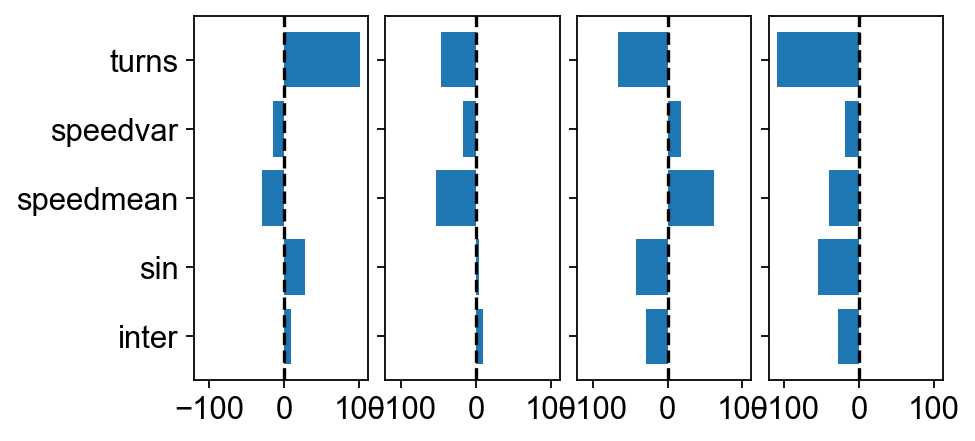

In [33]:
fig, ax = plt.subplots(1,4,sharey=True,sharex=True,figsize=(6,3),gridspec_kw=dict(wspace=0.1))
for i in range(4):
    df=sc.get.rank_genes_groups_df(adata,str(i))
    df=df.loc[df.sort_values("names").index]
    df.set_index("names")
    
    ax[i].barh(df.names,df.scores)
    ax[i].axvline(0,linestyle="--",color="k")
    ax[i].grid(False)
plt.savefig("figures/Clusters_zscores.pdf")

In [34]:
import umap
reducer = umap.UMAP(random_state=42,metric="correlation")
embedding = reducer.fit_transform(x)
emb=pd.DataFrame(embedding)

In [35]:
emb["specie"]=species
emb=emb.rename(columns={0: "UMAP1",1:"UMAP2"})
emb.loc[:,"UMAP2"]=-emb.loc[:,"UMAP2"]
emb.loc[:,"UMAP1"]=-emb.loc[:,"UMAP1"]

(-17.589080142974854,
 5.0561497688293455,
 -18.667321348190306,
 7.344238424301148)

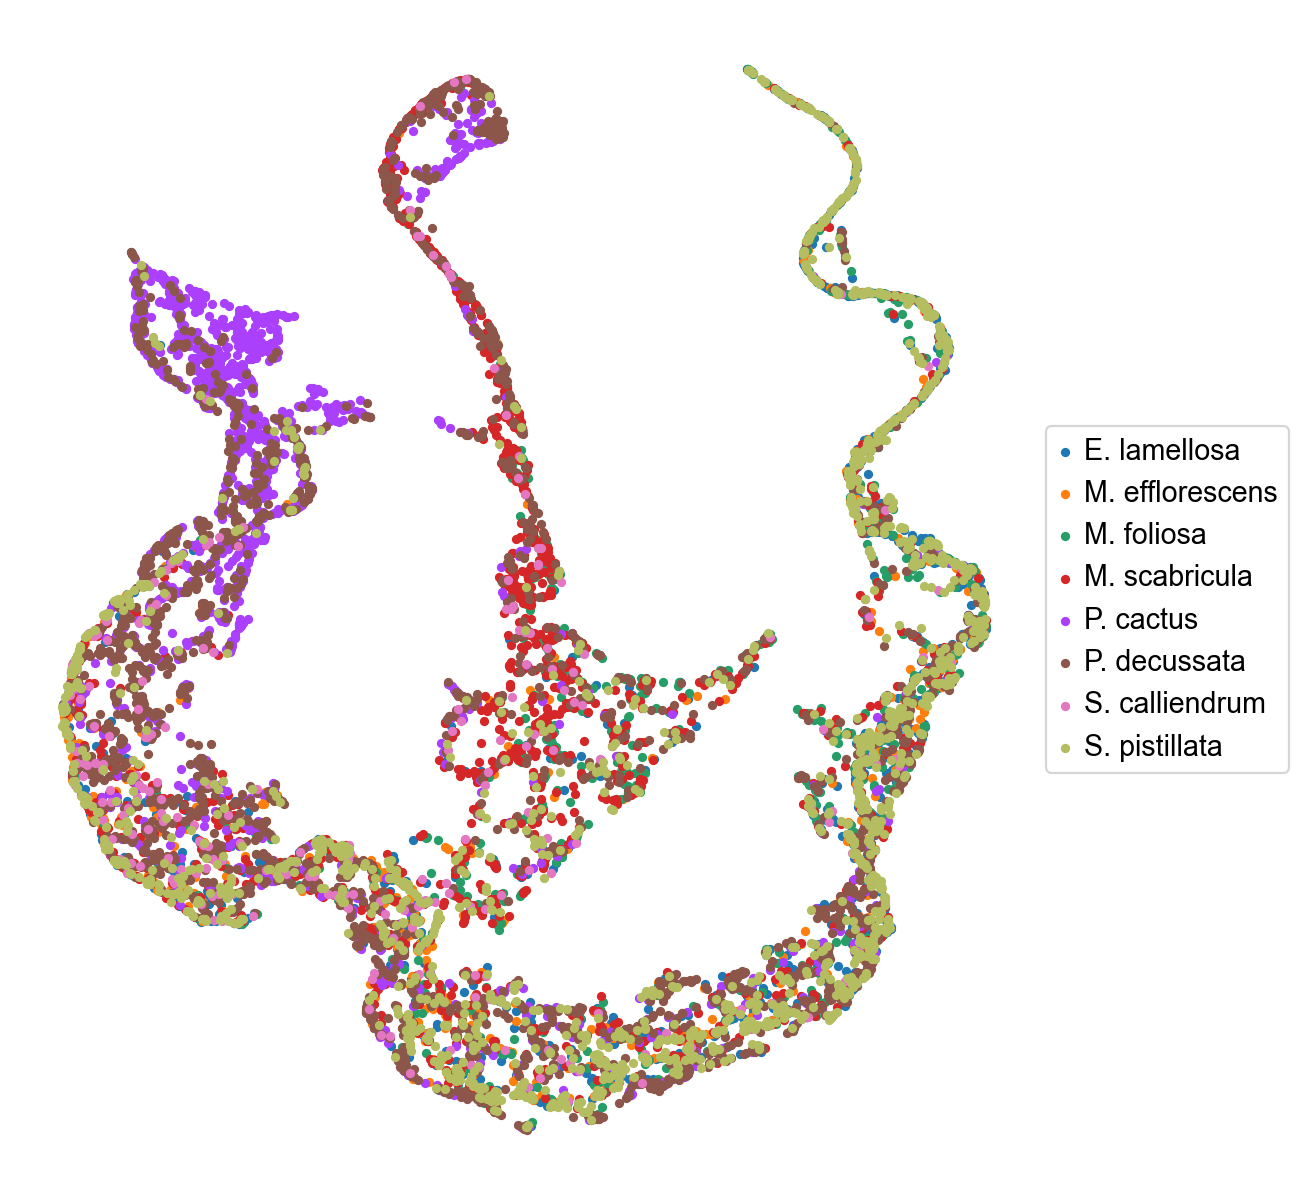

In [36]:
groups = emb.groupby('specie')
fig, ax = plt.subplots(figsize=(8,8),dpi=80)
ax.set_aspect('equal')
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
for name, group in groups:
    ax.scatter(group.UMAP1, group.UMAP2, marker='o', label=name,s=10)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
fig.tight_layout()
plt.axis('off')
#plt.savefig("UMAP_species.svg")